In [1]:
import requests
import pandas as pd
from collections.abc import MutableMapping
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

## Retrieve data

The following code block calls the LAWIS API and saves all incidents in a .csv file.

In [ ]:
# set up the initial parameters for the API request
url = "https://lawis.at/lawis_api/public/incident"
params = {
    "startDate": "1900-01-01",
    "endDate": "2023-03-07",
}
headers = {"Accept": "application/json"}

# make the initial request and get the incident IDs
response = requests.get(url, params=params, headers=headers)
incident_ids = [incident["id"] for incident in response.json()]

# initialize an empty list to store the incident data
incident_data = []

# define a recursive function to flatten the incident data
def flatten_dict(d, parent_key='', sep='_'):
    """
    Recursively flattens a nested dictionary into a flat dictionary by combining nested keys
    with a separator to create unique keys.

    Parameters:
        d (dict): The dictionary to flatten.
        parent_key (str): The prefix to add to flattened keys.
        sep (str): The separator to use between keys in the flattened dictionary.

    Returns:
        dict: The flattened dictionary.
    """
    items = []
    for k, v in d.items():
        # combine the current key with the parent key using the separator
        new_key = parent_key + sep + k if parent_key else k

        # if the value is a dictionary, recursively call the function to flatten it
        if isinstance(v, MutableMapping):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            # if the value is not a dictionary, add it to the list of items as a tuple
            items.append((new_key, v))
    # convert the list of items back to a dictionary and return it
    return dict(items)

for incident_id in incident_ids:
    url = f"https://lawis.at/lawis_api/public/incident/{incident_id}"
    response = requests.get(url, headers=headers)
    incident = response.json()
    
    # flatten all dictionaries into separate columns
    flat_incident = flatten_dict(incident)
    
    # add the flattened incident to the list
    incident_data.append(flat_incident)

# convert the incident data to a pandas DataFrame
df = pd.DataFrame(incident_data)

df.to_csv('data/avalanche_data.csv', index=False)

## First data exploration

In [2]:
# load the dataset
complete_df = pd.read_csv('data/avalanche_data.csv')

In [3]:
#only keep relevant columns
df = complete_df[['id', 'date', 'involved_dead', 'involved_injured',
       'involved_uninjured', 'involved_sweeped', 'involved_buried_partial',
       'involved_buried_total', 'danger_rating_level', 'danger_rating_text', 'avalanche_extent_length',
       'avalanche_extent_width', 'avalanche_breakheight', 'avalanche_type_id',
       'avalanche_type_text', 'avalanche_size_id', 'avalanche_size_text',
       'location_name', 'location_longitude', 'location_latitude',
       'location_aspect_id', 'location_aspect_text', 
       'location_country_code', 'location_elevation',
       'location_slope_angle']].copy()

total_incidents = len(df)
involved_incidents = len(df[(df['involved_dead'] > 0) | (df['involved_injured'] > 0) | (df['involved_uninjured'] > 0) | (df['involved_sweeped'] > 0)])

total_deaths = df['involved_dead'].sum()
total_injured = df['involved_injured'].sum()


# print basic stats to get an idea about the dataset
print(f'Incidents in Dataset: {total_incidents} \nIncidents involving people: {involved_incidents} \nDeaths: {total_deaths}\nInjured {total_injured}')

# show the ten deadliest avalanches
display(df.sort_values('involved_dead', ascending=False).head(10))


Incidents in Dataset: 3976 
Incidents involving people: 2342 
Deaths: 586.0
Injured 896.0


,id,date,involved_dead,involved_injured,involved_uninjured,involved_sweeped,involved_buried_partial,involved_buried_total,danger_rating_level,danger_rating_text,...,avalanche_size_id,avalanche_size_text,location_name,location_longitude,location_latitude,location_aspect_id,location_aspect_text,location_country_code,location_elevation,location_slope_angle
412,7012,1999-02-23T00:00:00+01:00,31.0,NaN,NaN,60.0,NaN,NaN,5.0,very high,...,NaN,NaN,Galtür - Wasserleiterlawine - Weisse Riepe,10.172831,46.982684,4.0,SE,AT,2700.0,40.0
449,7048,1999-12-28T00:00:00+01:00,9.0,0.0,NaN,15.0,3.0,12.0,4.0,high,...,NaN,NaN,Jamtalhütte - Steinmannli,10.176278,46.883814,8.0,NW,AT,2230.0,41.0
421,7021,1999-02-24T00:00:00+01:00,7.0,1.0,NaN,19.0,10.0,9.0,5.0,very high,...,NaN,NaN,Valzur -,10.213076,47.006760,NaN,NaN,AT,2560.0,NaN
1663,8041,2009-05-02T00:00:00+02:00,6.0,0.0,NaN,6.0,0.0,6.0,3.0,considerable,...,NaN,NaN,Schalfkogel -,10.967963,46.805994,2.0,NE,AT,3180.0,40.0
3257,9858,2020-03-08T09:15:00+01:00,5.0,0.0,0.0,0.0,0.0,0.0,3.0,considerable,...,3.0,3: large avalanche,Hallstatt,13.608800,47.476690,2.0,NE,AT,2700.0,40.0
3742,10404,2022-02-04T12:45:00+01:00,5.0,1.0,0.0,6.0,0.0,6.0,3.0,considerable,...,3.0,3: large avalanche,Fließer Berg,10.421820,46.990220,2.0,NE,AT,2400.0,40.0
741,311,2016-02-06T12:11:00+01:00,5.0,2.0,6.0,13.0,3.0,10.0,3.0,considerable,...,3.0,3: large avalanche,Geier,11.636490,47.146470,2.0,NE,AT,2620.0,38.0
2931,9575,2019-01-12T16:15:00+01:00,4.0,0.0,0.0,4.0,0.0,4.0,2.0,moderate,...,2.0,2: medium avalanche,"Rüfikopf - Variante ""Wasserschloss"" Richtung W...",10.166630,47.212920,2.0,NE,AT,1900.0,40.0
3039,9757,2019-04-26T10:00:00+02:00,4.0,0.0,0.0,0.0,0.0,4.0,3.0,considerable,...,6.0,unknown,Grünhornlücke,8.080870,46.516250,6.0,SW,CH,3400.0,NaN
569,7166,2001-02-23T00:00:00+01:00,4.0,0.0,NaN,7.0,1.0,4.0,4.0,high,...,NaN,NaN,Königsgrat - Obergurgl,11.052394,46.878215,8.0,NW,AT,2500.0,38.0


We learn that the dataset contains 3976 incidents of which 2342 involved people.
896 people were injured by the avalanches in the dataset and 586 people lost their lives.

The most devastating avalanche in the dataset was the 1999 Galtür avalanche which killed 31 people.

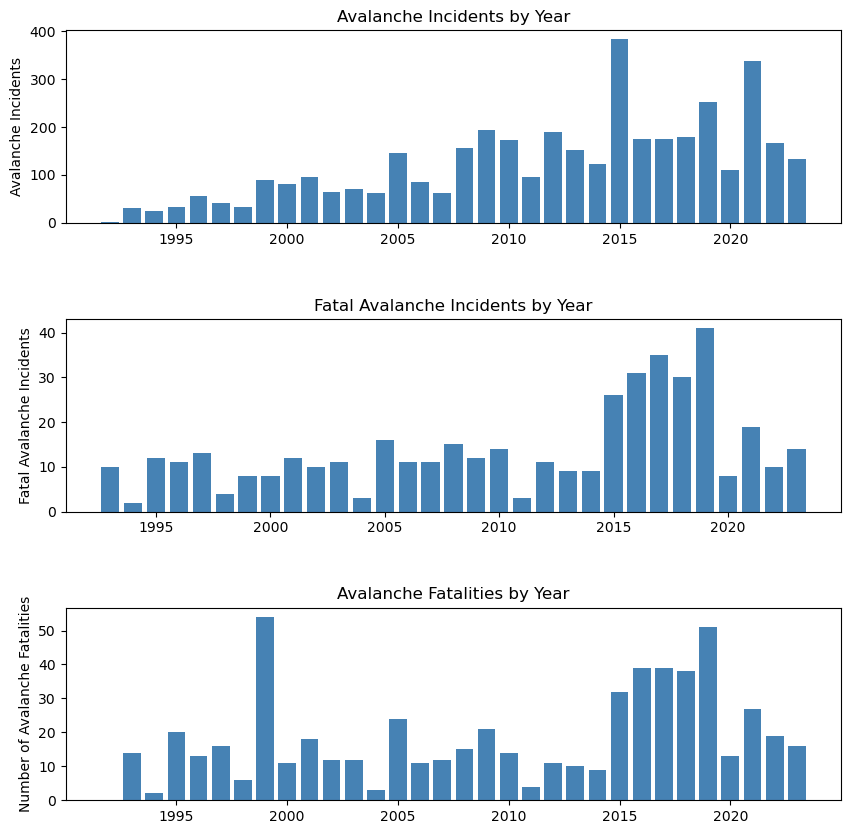

In [59]:
# Convert the 'date' column to a datetime object
df['date'] = pd.to_datetime(df['date'], utc=True)



# Get the number of incidents by year
incidents_by_year = df.groupby(df['date'].dt.year).size()

# Get the number of fatal incidents by year
fatal_incidents_by_year = df[df['involved_dead'] > 0].groupby(df['date'].dt.year).size()

# Group the data by year and sum the 'involved_dead' column for each group
fatalities_by_year = df.groupby(df['date'].dt.year)['involved_dead'].sum()


# Create a barplot of the incidents by year
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize=(10, 10))


ax1.bar(incidents_by_year.index, incidents_by_year.values, color='steelblue')
ax1.set_ylabel('Avalanche Incidents')
ax1.set_title('Avalanche Incidents by Year')

ax2.bar(fatal_incidents_by_year.index, fatal_incidents_by_year.values, color='steelblue')
ax2.set_ylabel('Fatal Avalanche Incidents')
ax2.set_title('Fatal Avalanche Incidents by Year')

ax3.bar(fatalities_by_year.index, fatalities_by_year.values, color='steelblue')
ax3.set_ylabel('Number of Avalanche Fatalities')
ax3.set_title('Avalanche Fatalities by Year')
fig.subplots_adjust(hspace=0.5)


plt.show()



The LAWIS Database went online in 2015, so we can assume that the reporting became more complete since then.

In [ ]:
# Most number of dead and injured in danger level 3
print(df.groupby('danger_rating_level')['involved_dead','involved_injured','involved_buried_partial','involved_buried_total'].sum())

print(df.columns)

In [ ]:
grouped = df.groupby('danger_rating_level').sum()[['involved_dead', 'involved_injured', 'involved_uninjured']].dropna()

grouped.plot(kind='bar', stacked=True)

grouped_relative = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the stacked bar chart
grouped_relative.plot(kind='bar', stacked=True)

# Add chart title and axis labels
plt.title('Stacked Bar Chart by Danger Rating (Relative Distribution)')
plt.xlabel('Danger Rating Level')
plt.ylabel('Relative Frequency')
plt.show()

##Map

I got interested in creating my own (animated) map of the incidents in the dataset. So I try to learn D3.js and leaflet.js basics. As a data source I need to save a csv with the relevant data.

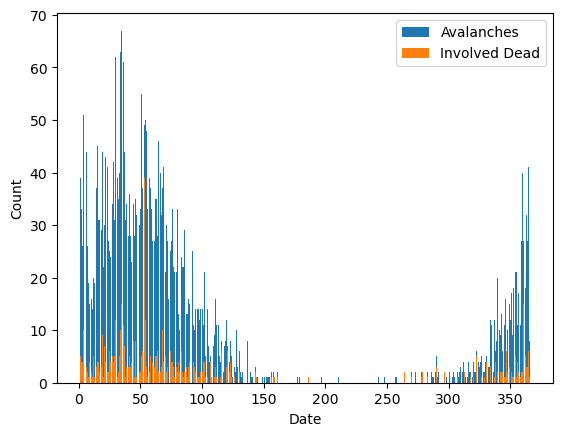

In [33]:
# Maybe we can visualize the data in a circular histogram to show when most of the avalanches occur.
# Exploratory Python Plot
import numpy as np

# Create a new column that extracts just the date (ignoring the time)
df['date_only'] = df['date'].dt.dayofyear

# Group the data by date and count the number of avalanches
avalanche_count = df.groupby('date_only')['id'].count()

# Group the data by date and sum the number of involved_dead
involved_dead_count = df.groupby('date_only')['involved_dead'].sum()

# Plot the two histograms on the same axis
fig, ax = plt.subplots()
ax.bar(avalanche_count.index, avalanche_count.values, label='Avalanches')
ax.bar(involved_dead_count.index, involved_dead_count.values, label='Involved Dead')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Count')
plt.show()

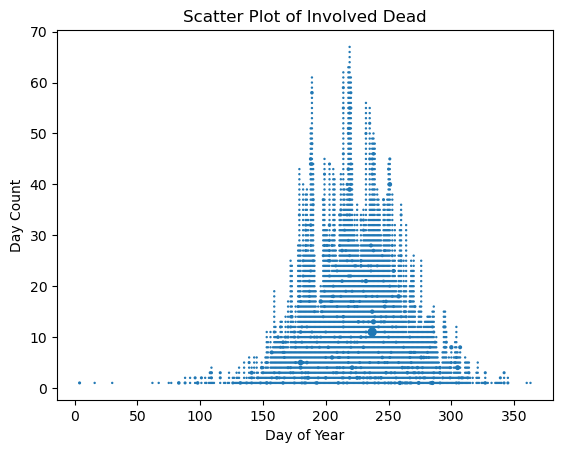

In [82]:

# fill NaN values in 'involved_dead' column with 0
df['involved_dead'] = df['involved_dead'].fillna(0)

# fill NaN values in 'involved_injured' column with 0
df['involved_injured'] = df['involved_injured'].fillna(0)

# add a new column for day of year
df['day_of_year'] = df['date'].dt.dayofyear

# adjust day_of_year for leap years
df['day_of_year'] -= (df['day_of_year'] >= 60) & df['date'].dt.is_leap_year
df['day_of_year'] = (df['day_of_year'] + 184) % 365 

# add a new column for day count
df['daycount'] = df.groupby('day_of_year').cumcount() + 1

# create the scatter plot
plt.scatter(df['day_of_year'], df['daycount'], s=df['involved_dead']+0.1*5)

# add axis labels and title
plt.xlabel('Day of Year')
plt.ylabel('Day Count')
plt.title('Scatter Plot of Involved Dead')

# display the plot
plt.show()

In [81]:
mapdata = df[['id', 'date', 'involved_dead', 'involved_injured', 'danger_rating_level', 'danger_rating_text', 'location_name', 'location_longitude', 'location_latitude', 'day_of_year', 'daycount']].copy()
#mapdata = mapdata.dropna()
#mapdata = mapdata[mapdata['date'] > '2015-01-01']
mapdata['danger_rating_level'] = mapdata['danger_rating_level'].fillna(0).astype(int)
mapdata.sort_values(by='date', inplace=True)
mapdata = mapdata.reset_index(drop=True)
mapdata.index.name = 'index'
mapdata.to_csv('D3/avalanche_data.csv', index=True)





In [ ]:
runningSum = df.groupby('date').sum()[['involved_dead', 'involved_injured', 'involved_uninjured']].dropna()
runningSum = runningSum.cumsum()
runningSum.plot.area(stacked=True)